# Set up

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this notebook specifically, beacuse we will use graphviz library to export image, we will need an image folder to store all the images to load it into the notebbook later.

In [36]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Training and Visualizing a Decision Tree

In [37]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

In [38]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [39]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=str(IMAGES_PATH / "iris_tree.dot"),
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

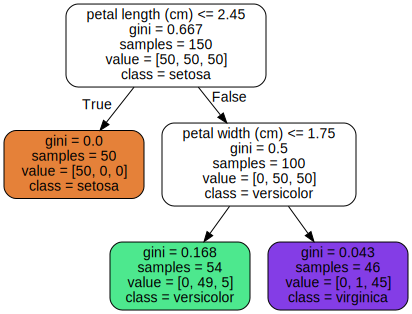

In [40]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")

# Making Predictions

In [41]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 200), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_predict = tree_clf.predict(X_iris_all).reshape(lengths.shape)

In [42]:
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [43]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf_deeper,
    out_file=str(IMAGES_PATH / "iris_tree_deeper.dot"),
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

If the node is not a leaf node, its color is white. If it is the leaf node, then the lower its gini impurity, the dark its color is. The color is distinct between classes.

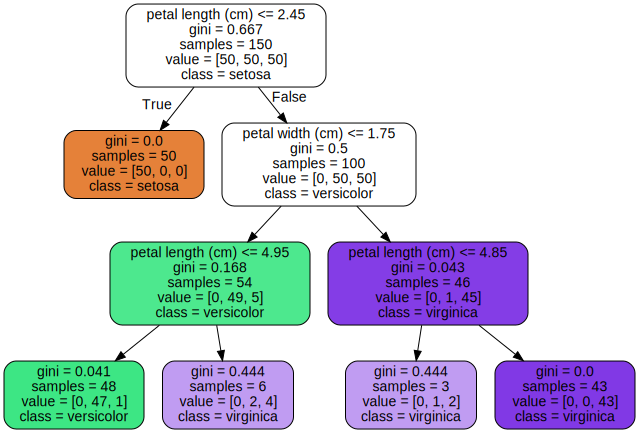

In [44]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree_deeper.dot")

In `DecisionTreeClassifier` class, the threshold attribute return an array of node index. For example, consider the above image, the way we count the index is similar to Deep First Search. In detail:
- Start from the root, its index is 0.
- Go to the left node, depth 1, its index increases to 1.
- Go to the right node, depth 1, its index increases to 2.
- Go to the left node, depth 2, its index increases to 3.
- Go to the leftmost node, depth 3, its index increases to 4.
- Go to the second-leftmost node, depth 3, its index increases to 5.
- Traverse back to the right node, depth 2, its index increases to 6.
- Go to the second-rightmost node, depth 3, its index increases to 7.
- Go to the rightmost node, depth 3, its index increases to 8.

You can hover the mouse on each node to see the index of that specific node.

In [45]:
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[
    [0, 2, 3, 6]
]  # Return the threshold for 0-th, 2-th, 3-rd, 6-th nodes.

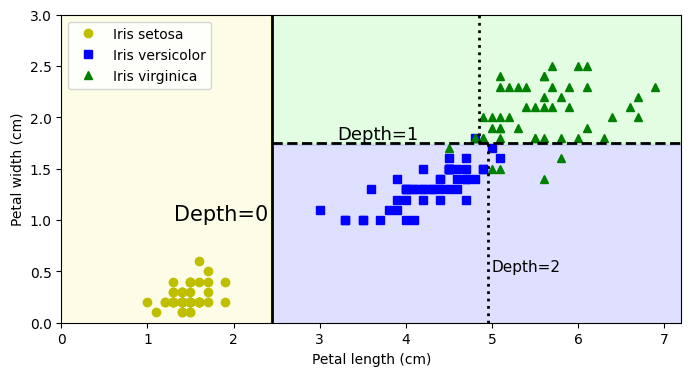

In [46]:
plt.figure(figsize=(8, 4))

plt.contourf(lengths, widths, y_predict, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(
        X_iris[:, 0][y_iris == idx],
        X_iris[:, 1][y_iris == idx],
        style,
        label=f"Iris {name}",
    )
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "Depth=2", horizontalalignment="left", fontsize=11)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
plt.show()

In [47]:
th1

1.75

You can access the tree structure via the `tree_` attribute.

In [48]:
tree_clf.tree_

For more information, please read this class's documentation.

In [49]:
import sklearn

help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

There will be an extra material at the end of this notebook, which shows an example.

# Estimating Class Probabilities

In [50]:
tree_clf.predict_proba([[5, 1.5]]).round(3) * 100

array([[ 0. , 90.7,  9.3]])

In [51]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters

In [52]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [53]:
def plot_decision_boundary(clf, X, y, axis, cmap):
    x1, x2 = np.meshgrid(
        np.linspace(axis[0], axis[1], 100), np.linspace(axis[2], axis[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_predict = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_predict, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_predict, alpha=0.8, cmap="Greys")
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ["o", "^"]
    for idx in [0, 1]:
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[cmap][idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axis)
    plt.xlabel("$x_1$")

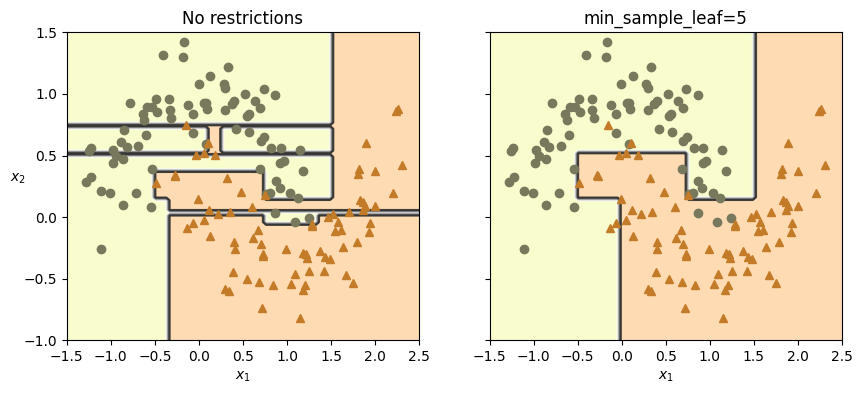

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons, [-1.5, 2.5, -1, 1.5], cmap="Wistia")
plt.ylabel("$x_2$", rotation=0)
plt.title("No restrictions")

plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons, [-1.5, 2.5, -1, 1.5], cmap="Wistia")
plt.title("min_sample_leaf=5")

plt.show()

# Regression

In [55]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad**2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

The higher the error, the darker the node.

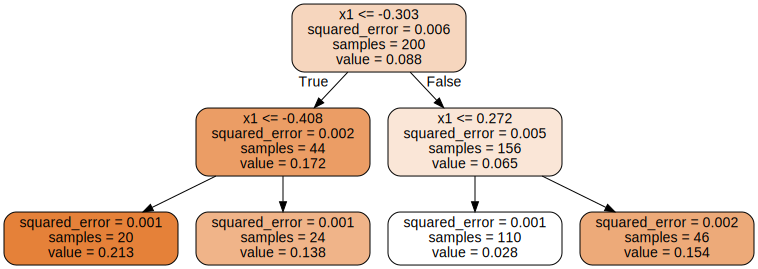

In [56]:
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True,
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

In [57]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [58]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [59]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

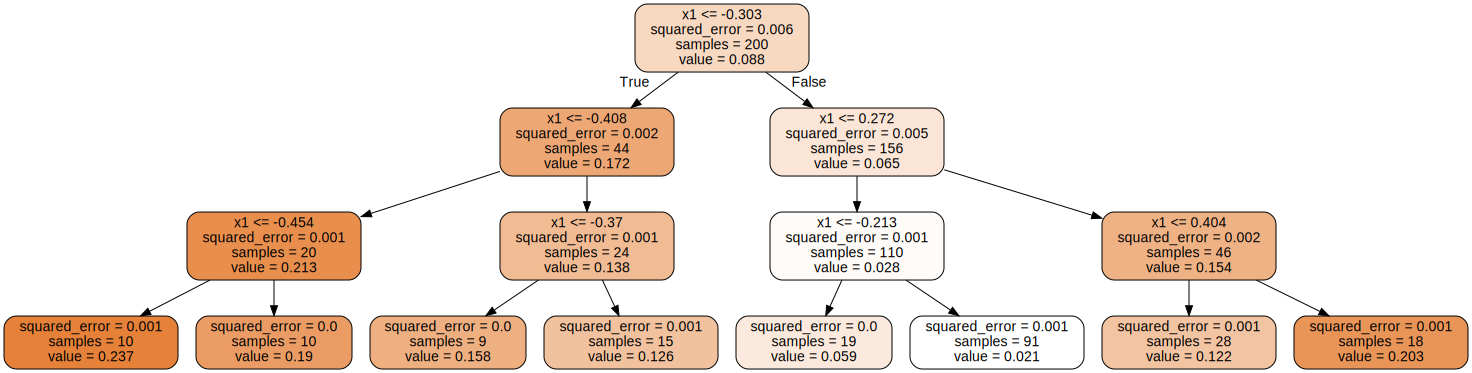

In [60]:
export_graphviz(
    tree_reg2,
    out_file=str(IMAGES_PATH / "regression_tree2.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True,
)
Source.from_file(IMAGES_PATH / "regression_tree2.dot")

In [61]:
def plot_regression_predictions(tree_reg, X, y, axis=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axis[0], axis[1], 500).reshape(-1, 1)
    y_predict = tree_reg.predict(x1)
    plt.axis(axis)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_predict, "r-", linewidth=2, label=r"$\hat{y}$")

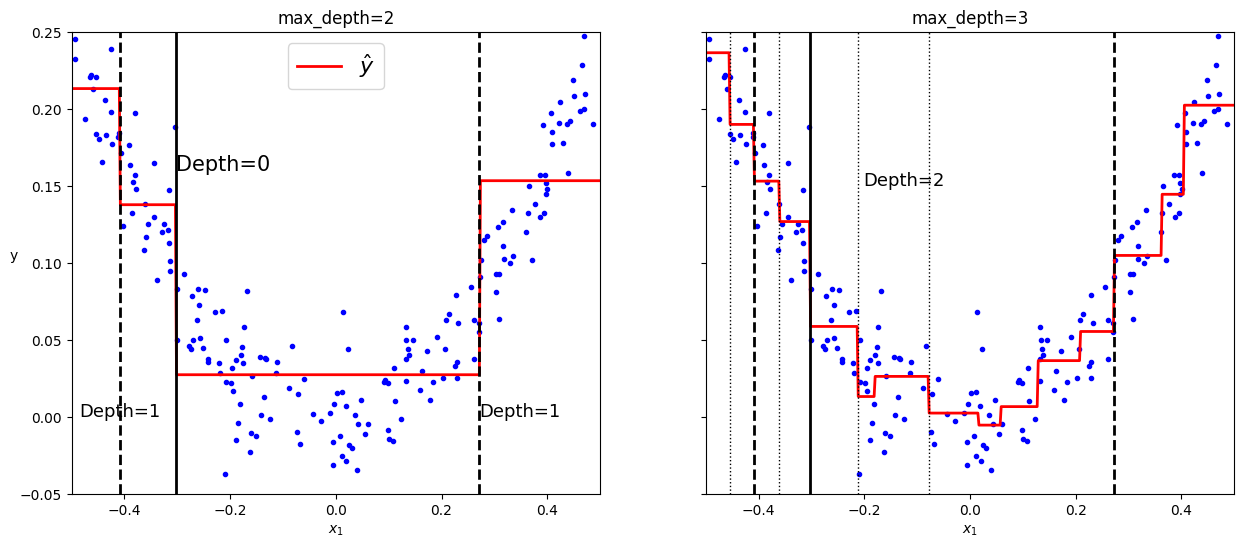

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in [(th0, "k-"), (th1a, "k--"), (th1b, "k--")]:
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a, 0, "Depth=1", ha="center", fontsize=13)
plt.text(th1b, 0, "Depth=1", fontsize=13)
plt.ylabel("y", rotation=0)
plt.xlabel("$x_1$")
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in [(th0, "k-"), (th1a, "k--"), (th1b, "k--")]:
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")
plt.xlabel("$x_1$")

plt.show()

In [66]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_predict1 = tree_reg1.predict(x1)
y_predict2 = tree_reg2.predict(x1)

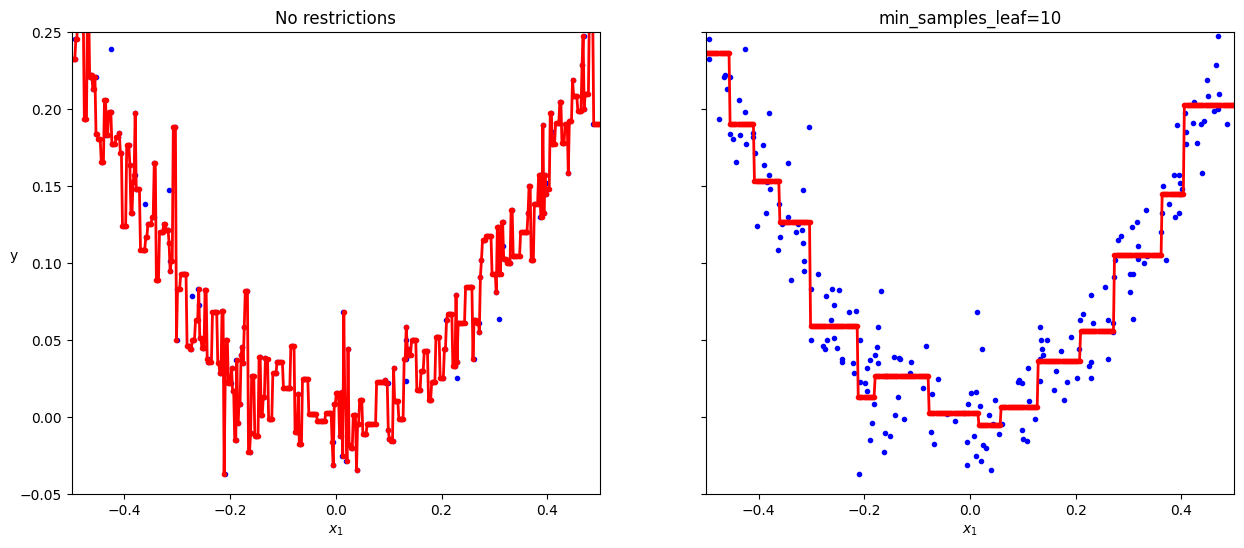

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_predict1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_predict2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title("min_samples_leaf=10")

plt.show()